# Exploring MTA Turnstile Data

The Metropolitan Transportation Authority (MTA), which serves around 11 million passengers in New York State daily,  routinely publishes their Turnstile Data showing the number of entries and exits at each turnstile, per hour. In this notebook, we're going to explore that data and identify:

* How traffic at Grand Central Terminal varies over time
* The Stations with the highest commuter traffic
* The Stations with the lowest commuter traffic

In this notebook, I'll be using helper functions in order to directly download the data from the MTAs website, and to cleanse the data - which is quite messy.

In [37]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import local helper functions
from import_data import import_data
from preprocessing import cleanse_data
from utils import weekday_weekend_traffic_differences

In [38]:
# set display options
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 500)
plt.rcParams["figure.figsize"] = (16,8)

In [39]:
# The import_data function downloads data from the date range directly from the MTA Website.
# You can replace the start_date and end_date with any date range.
start_date = datetime.datetime(2019, 6, 16)
end_date = datetime.datetime(2019, 7, 16)

turnstile_df = import_data(start_date, end_date)

100%|██████████| 4/4 [00:36<00:00,  9.92s/it]


In [41]:
# The Raw Data is incredibly messy. Entries and Exits are cummalative, 
# there are multiple anomalous entries that make no sense, 
# some of the columns have white spaces, etc. etc.
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2019,00:00:00,REGULAR,7124325,2412359
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2019,04:00:00,REGULAR,7124336,2412362
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2019,08:00:00,REGULAR,7124350,2412390
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2019,12:00:00,REGULAR,7124442,2412471
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2019,16:00:00,REGULAR,7124608,2412505


In [42]:
# I've written a couple of functions to do all the data cleansing,
# and feature engineering to declutter the notebook
turnstile_df = cleanse_data(turnstile_df)

In [46]:
# entries and exits are no longer cumulative
turnstile_df.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,DATETIME,TURNSTILE_ID,ENTRIES,EXITS,WDAY,WEEKDAY,WEEK,HOUR,LATITUDE,LONGITUDE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/15/2019,04:00:00,REGULAR,2019-06-15 04:00:00,A002_R051_02-00-00_59 ST,29,3,5,Saturday,24,4,40.766185,-73.977304
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/15/2019,08:00:00,REGULAR,2019-06-15 08:00:00,A002_R051_02-00-00_59 ST,33,26,5,Saturday,24,8,40.766185,-73.977304
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/15/2019,12:00:00,REGULAR,2019-06-15 12:00:00,A002_R051_02-00-00_59 ST,99,87,5,Saturday,24,12,40.766185,-73.977304


In [49]:
# Show Data from a Turnstile at Grand Central Terminal for a Week in June 2019
date_mask = (turnstile_df["DATETIME"] > datetime.datetime(2019,6,17)) & \
            (turnstile_df["DATETIME"] < datetime.datetime(2019, 6,24)) & \
            (turnstile_df["TURNSTILE_ID"] == 'R236_R045_00-00-00_GRD CNTRL-42 ST')

grand_central_turnstile = turnstile_df.loc[date_mask]

# resample data at four hour intervals
new_gct = grand_central_turnstile.resample("4H", base=1, on="DATETIME", label="left").sum()

In [50]:
new_gct.head()

,ENTRIES,EXITS,WDAY,WEEK,HOUR,LATITUDE,LONGITUDE
DATETIME,,,,,,,
2019-06-17 01:00:00,40,69,0,25,1,40.752726,-73.977229
2019-06-17 05:00:00,0,0,0,0,0,0.000000,0.000000
2019-06-17 09:00:00,53,1560,0,25,9,40.752726,-73.977229
2019-06-17 13:00:00,221,1455,0,25,13,40.752726,-73.977229
2019-06-17 17:00:00,602,859,0,25,17,40.752726,-73.977229


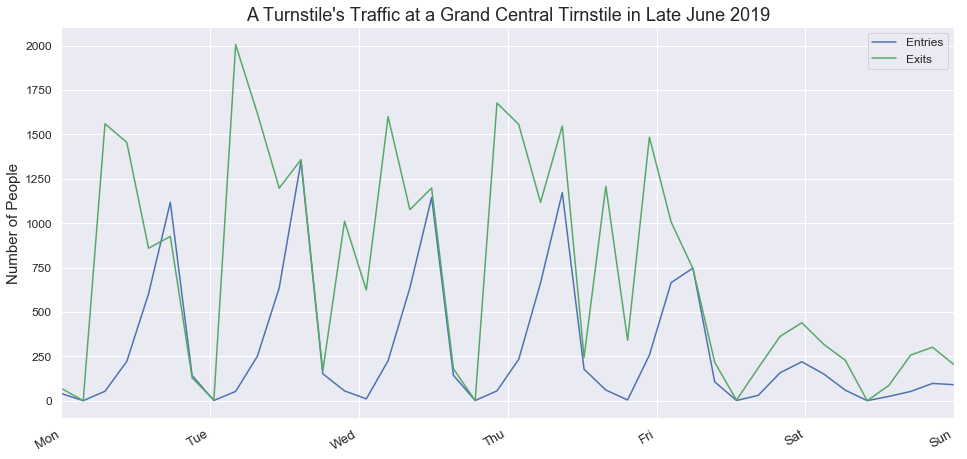

In [78]:
sns.set()
days_of_the_week = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax = new_gct.plot.line(y="ENTRIES", use_index=False)
new_gct.plot.line(ax=ax, y="EXITS", style='g', use_index=False)
 
ax.set_ylabel("Number of People", fontsize=15)
ax.set_xlabel("")
ax.set_title("A Turnstile's Traffic at a Grand Central Tirnstile in Late June 2019", fontsize=18)
ax.set_xticklabels(days_of_the_week)
ax.set_xticks(np.linspace(0, 41, 7))
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)
ax.legend(["Entries", "Exits"], prop={'size': 12});

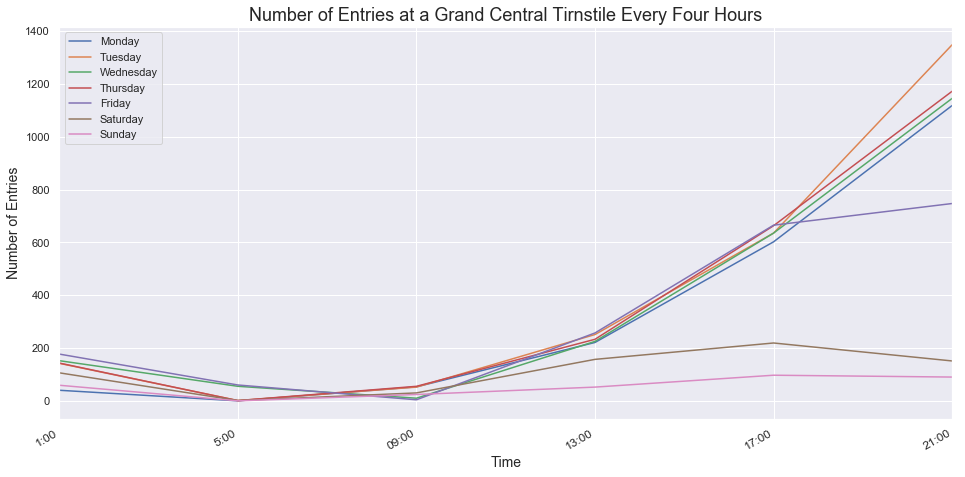

In [79]:
sns.set()
xtick_times = "1:00 5:00 09:00 13:00 17:00 21:00".split()

# Traffic at a Turnstile on Monday
ax = new_gct[0:6].plot.line(y='ENTRIES', use_index=False)

# Traffic at a Turnstile Tuesday through Sunday
for x in range(6, 42, 6):
    new_gct[x:x+6].plot.line(ax=ax, y="ENTRIES", use_index=False)
    
ax.set_xticks(np.arange(6))
ax.set_xticklabels(xtick_times)
ax.legend(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Number of Entries", fontsize=14)
ax.set_title("Number of Entries at a Grand Central Tirnstile Every Four Hours", fontsize=18)
plt.yticks(fontsize=11)
plt.xticks(fontsize=12);

In [61]:
# Group all the Turnstiles in Grand Central Terminal for a Week in June 2019

grouped_turnstiles = turnstile_df.groupby(["STATION", "DATETIME"]).sum().reset_index()

mask = (grouped_turnstiles["DATETIME"] > datetime.datetime(2019,6,17)) \
& (grouped_turnstiles["DATETIME"] < datetime.datetime(2019, 6,24)) \
& (grouped_turnstiles["STATION"] == 'GRD CNTRL-42 ST')

gct_tirnstiles = grouped_turnstiles.loc[mask]


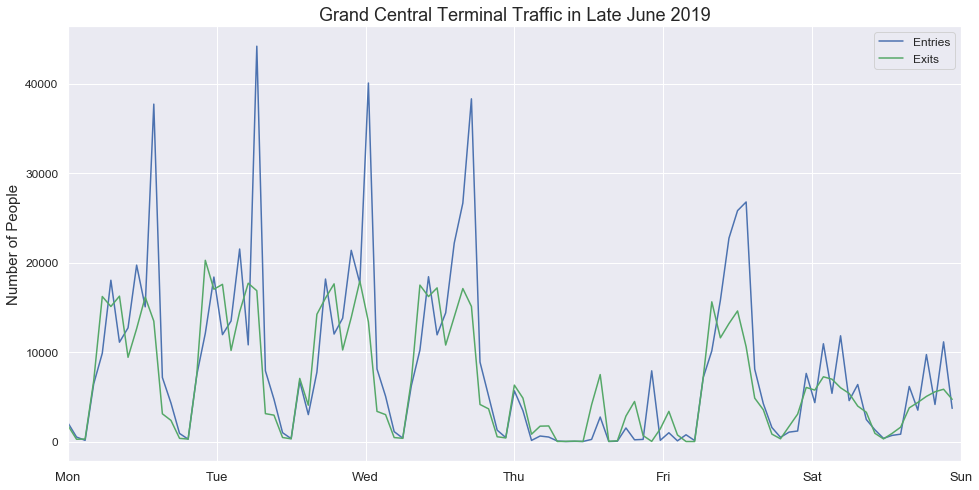

In [80]:
# Look at all traffic in Grand Central Terminal for a Week in 2019
days_of_the_week = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax = gct_tirnstiles.plot.line(y="ENTRIES", use_index=False)
gct_tirnstiles.plot.line(ax=ax, y="EXITS", style='g', use_index=False)
 
ax.set_ylabel("Number of People", fontsize=15)
ax.set_xlabel("")
ax.set_title("Grand Central Terminal Traffic in Late June 2019", fontsize=18)
ax.set_xticklabels(days_of_the_week)
ax.set_xticks(np.linspace(0, 104, 7))
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)
ax.legend(["Entries", "Exits"], prop={'size': 12})

In [63]:
gct_data = turnstile_df.loc[turnstile_df["STATION"] == "GRD CNTRL-42 ST"]
daily_gct_data = gct_data.resample('D', base=0, on="DATETIME", label='left').sum()\
                        .reset_index().drop(["WDAY", "WEEK", "HOUR"], axis=1)

daily_gct_data.head()

,DATETIME,ENTRIES,EXITS,LATITUDE,LONGITUDE
0,2019-06-15,48635,46598,11003.236074,-19973.851938
1,2019-06-16,46290,41572,12755.603301,-23154.872802
2,2019-06-17,139889,110206,13326.141467,-24190.554014
3,2019-06-18,152487,127585,13855.926908,-25152.257996
4,2019-06-19,154566,121274,14670.981432,-26631.802584


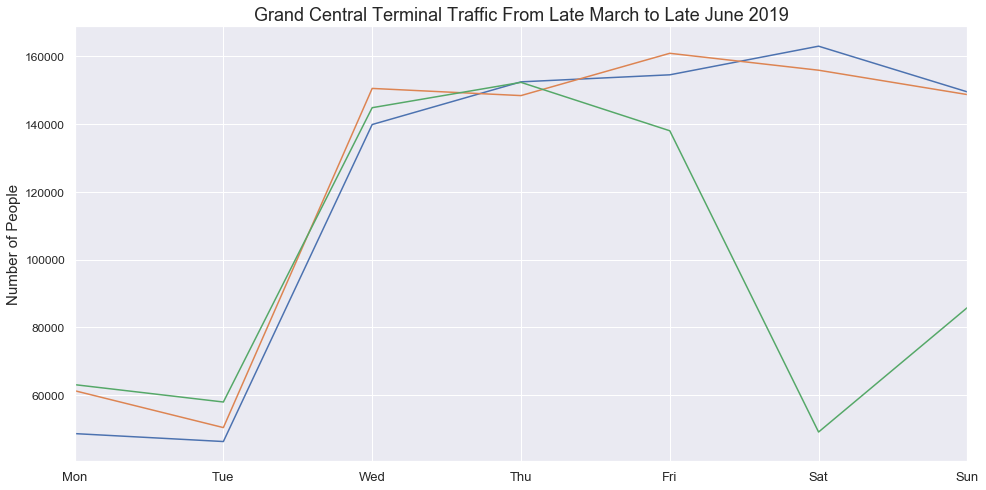

In [81]:
# Look at Daily Traffic for Grand Central Terminal
days_of_the_week = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
ax = daily_gct_data[0:7].plot.line(y="ENTRIES", use_index=False)

for i in range(7, (len(daily_gct_data) - 7), 7):
    daily_gct_data[i:i+7].plot.line(ax=ax, y="ENTRIES", use_index=False)

ax.set_ylabel("Number of People", fontsize=15)
ax.set_xlabel("")
ax.set_title("Grand Central Terminal Traffic From Late March to Late June 2019", fontsize=18)
ax.set_xticklabels(days_of_the_week)
ax.set_xticks(np.linspace(0, 6, 7))
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)
ax.get_legend().remove()
plt.savefig("GCT Total Long Traffic.svg");

In [65]:
total_ridership_count = turnstile_df.groupby("STATION").sum().sort_values("ENTRIES", ascending=False)
total_ridership_count.head()

,ENTRIES,EXITS,WDAY,WEEK,HOUR,LATITUDE,LONGITUDE
STATION,,,,,,,
34 ST-PENN STA,3943616,3553992,47667,421754,172483,653961.172271,-1.187405e+06
GRD CNTRL-42 ST,3305843,2609092,28934,259330,106566,402433.171225,-7.305251e+05
34 ST-HERALD SQ,2832196,2633129,25994,228143,90085,353741.182670,-6.422967e+05
23 ST,2594169,1906092,30439,271436,109400,421836.156124,-7.661062e+05
TIMES SQ-42 ST,2423024,2331916,24314,214862,81807,333545.967242,-6.055101e+05


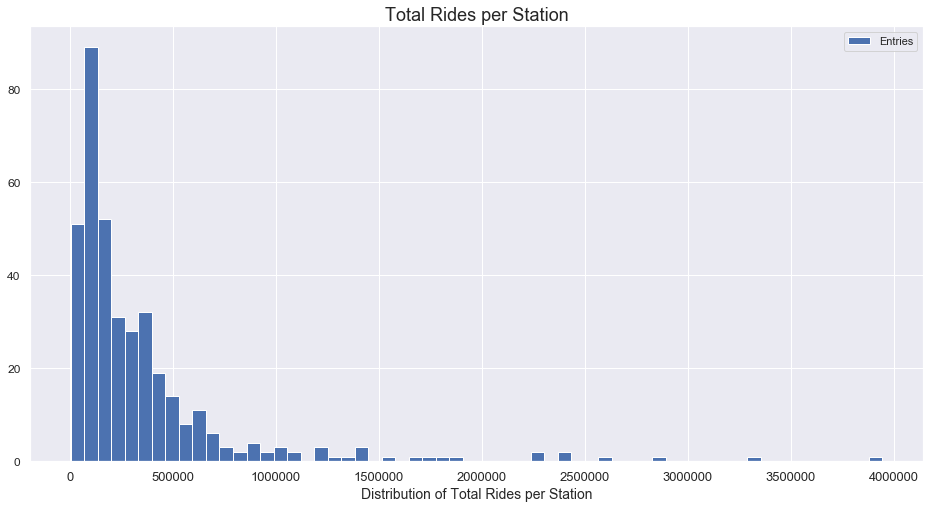

In [82]:
ax = total_ridership_count.plot.hist(y="ENTRIES", bins=60)

ax.set_xlabel("Distribution of Total Rides per Station", fontsize=14)
ax.set_ylabel('')
ax.set_title("Total Rides per Station", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=13)
ax.legend(["Entries"]);

In [67]:
# Calculate the difference between average traffic during the week, and average traffic on Weekends.
traffic_differences = weekday_weekend_traffic_differences(turnstile_df.reset_index(), week=25)

In [68]:
traffic_differences.head()

,STATION,LATITUDE,LONGITUDE,Entry_diffs,Exit_diffs
0,1 AV,40.763368,-73.959240,11471.8,12123.2
2,103 ST,40.790280,-73.947599,18973.2,10205.0
4,103 ST-CORONA,40.748706,-73.862884,6989.2,4500.4
6,104 ST,40.799797,-73.967307,2050.8,485.7
8,110 ST,40.798268,-73.952514,4159.2,2831.1


In [70]:
# Identify the stations with the highest and lowest differences between average entrances / exits 
# between Weekdays and Weekends.
highest_entry_diffs = traffic_differences.sort_values("Entry_diffs", ascending=False).head(7)
high_exit_diffs = traffic_differences.sort_values("Exit_diffs", ascending=False).head(7)

lowest_entry_diffs = traffic_differences.sort_values("Entry_diffs", ascending=True).head(7)
lowest_exit_diffs = traffic_differences.sort_values("Exit_diffs", ascending=True).head(7)

# Analyzing Commuter Traffic

Stations with the biggest difference in traffic between Weekdays and Weekends are probably also the stations with the most commuters. The weekday_weekend_traffic_differences function calculates the average difference in traffic between Weekdays and Weekends. Below I've identified that
* Grand Central, 34th Penn Street, and 23rd Street have the highest surplus of entries during the week
* 34th Penn Street, Grand Central Terminal, and Fulton have the highest surplus of exits during the week
* Coney Island has by far the highest surplus of entries on the weekend
* The Mets' baseball stadium has the highest surplus of exits on the weekend

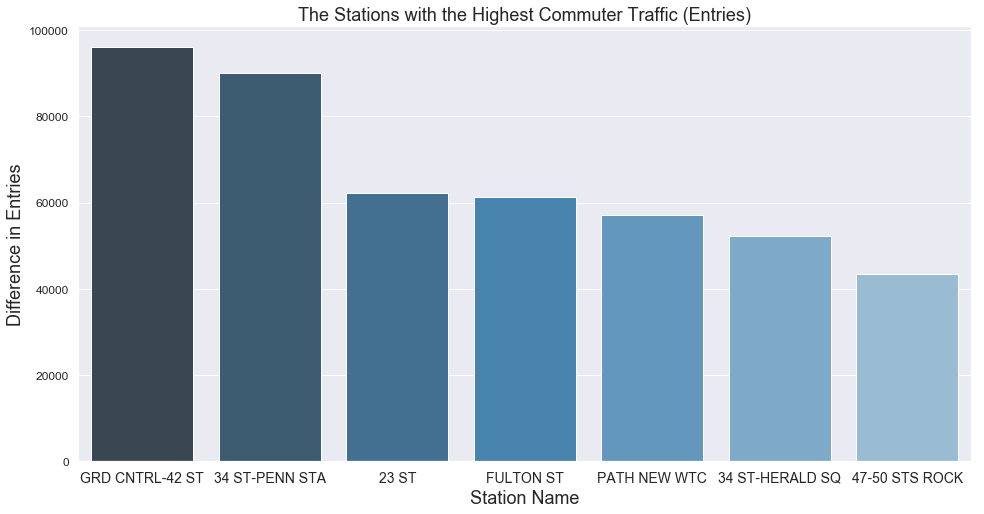

In [83]:
ax = sns.barplot(x="STATION", y="Entry_diffs", data=highest_entry_diffs, palette=('Blues_d'))

ax.set_xlabel("Station Name", fontsize=18)
ax.set_ylabel("Difference in Entries", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
ax.set_title("The Stations with the Highest Commuter Traffic (Entries)", fontsize=18);

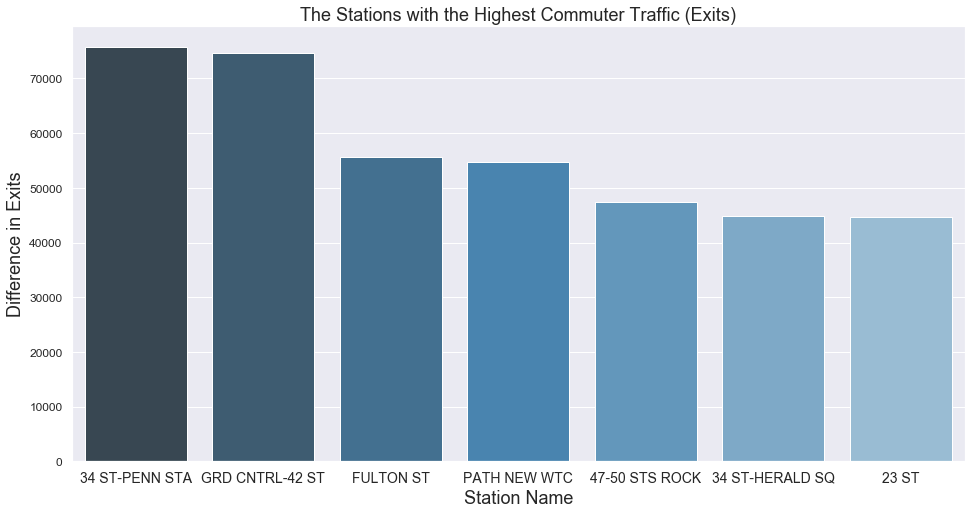

In [84]:
ax = sns.barplot(x="STATION", y="Exit_diffs", data=high_exit_diffs, palette=('Blues_d'))

ax.set_xlabel("Station Name", fontsize=18)
ax.set_ylabel("Difference in Exits", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
ax.set_title("The Stations with the Highest Commuter Traffic (Exits)", fontsize=18);

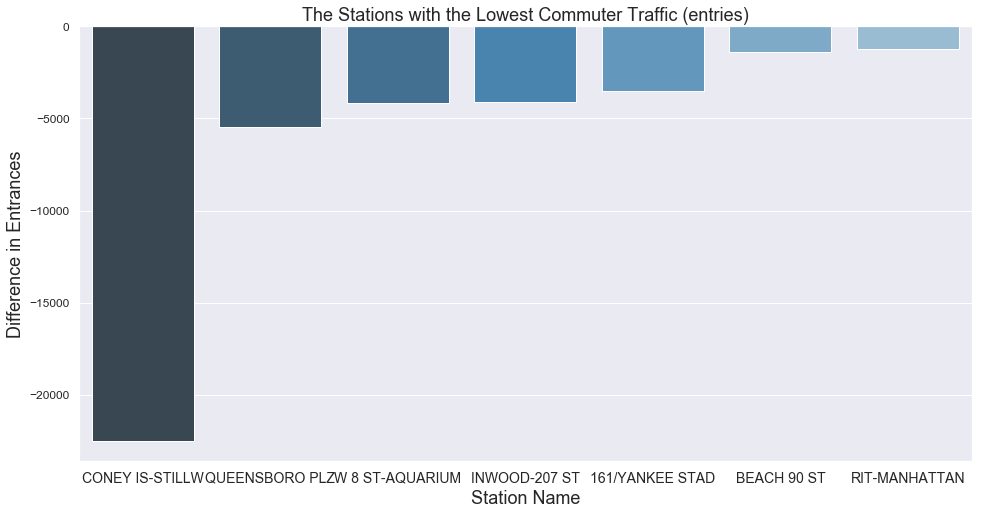

In [85]:
#These Stations Actually Have More Traffic on the Weekend Than During the Week.
ax = sns.barplot(x="STATION", y="Entry_diffs", data=lowest_entry_diffs, palette=('Blues_d'))

ax.set_xlabel("Station Name", fontsize=18)
ax.set_ylabel("Difference in Entrances", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
ax.set_title("The Stations with the Lowest Commuter Traffic (entries)", fontsize=18);

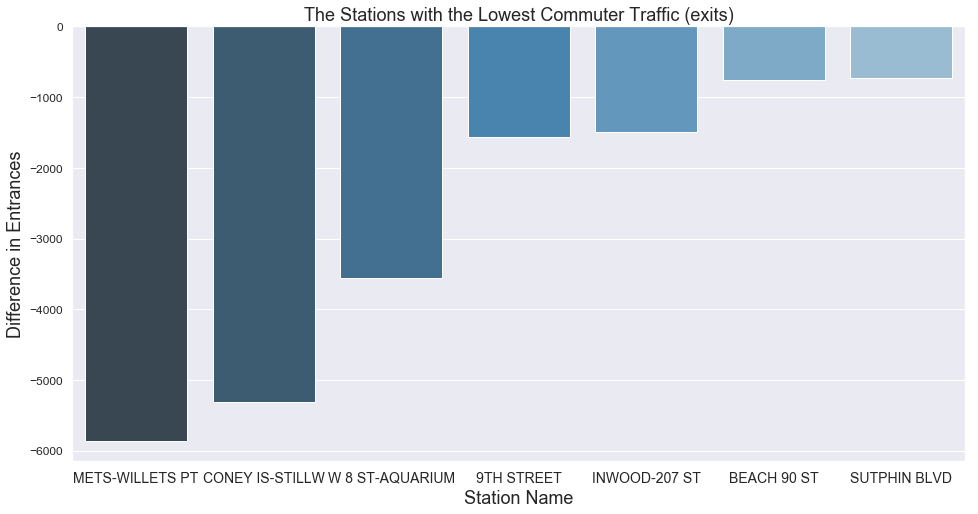

In [86]:
#These Stations Actually Have More Traffic on the Weekend Than During the Week.
ax = sns.barplot(x="STATION", y="Exit_diffs", data=lowest_exit_diffs, palette=('Blues_d'))

ax.set_xlabel("Station Name", fontsize=18)
ax.set_ylabel("Difference in Entrances", fontsize=18)
plt.yticks(fontsize=12)
plt.xticks(fontsize=14)
ax.set_title("The Stations with the Lowest Commuter Traffic (exits)", fontsize=18);